In [2]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [3]:
dataset_filepath = 'data/dataset/weatherHistory.csv'
df = pd.read_csv(dataset_filepath)

df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
univariate_df = df['Temperature (C)']
univariate_df.index = df['Formatted Date']

In [5]:
univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

In [6]:
input_size = 6
label_size = 1
offset = 1

def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = []
    labels = []
    
    window_size = input_size + offset
    
    if df_end_idx is None:
        df_end_idx = len(df) - window_size
    
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size
        label_start_idx = idx + window_size - label_size
        
        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx + window_size)]
        
        features.append(feature)
        labels.append(label)
    
    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)
    
    return features, labels

In [7]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2
train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

In [8]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y

# Create datasets
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

# Define batch sizes
train_batch_size = 128
test_batch_size = 8

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [9]:
class WeatherForecastor(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize model parameters
embedding_dim = 1
hidden_size = 8
n_layers = 3
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the model
model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

# Define loss function and optimizer
lr = 1e-3
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [11]:
train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, device, epochs
)

EPOCH 1:	Train loss: 126.5261	Val loss: 40.6979
EPOCH 2:	Train loss: 29.9595	Val loss: 7.4822
EPOCH 3:	Train loss: 16.1813	Val loss: 3.5673
EPOCH 4:	Train loss: 13.1765	Val loss: 3.0718
EPOCH 5:	Train loss: 11.5970	Val loss: 2.0178
EPOCH 6:	Train loss: 10.7809	Val loss: 2.3695
EPOCH 7:	Train loss: 10.0049	Val loss: 2.7381
EPOCH 8:	Train loss: 9.5437	Val loss: 2.0497
EPOCH 9:	Train loss: 9.4036	Val loss: 1.8293
EPOCH 10:	Train loss: 9.0557	Val loss: 1.9996
EPOCH 11:	Train loss: 9.0126	Val loss: 1.5838
EPOCH 12:	Train loss: 8.7332	Val loss: 1.8631
EPOCH 13:	Train loss: 8.6026	Val loss: 1.9579
EPOCH 14:	Train loss: 8.3403	Val loss: 1.6885
EPOCH 15:	Train loss: 8.2734	Val loss: 1.9796
EPOCH 16:	Train loss: 8.0663	Val loss: 2.1195
EPOCH 17:	Train loss: 7.8379	Val loss: 1.6398
EPOCH 18:	Train loss: 7.7163	Val loss: 1.6172
EPOCH 19:	Train loss: 7.6191	Val loss: 1.6292
EPOCH 20:	Train loss: 7.4775	Val loss: 1.8229
EPOCH 21:	Train loss: 7.3221	Val loss: 1.6151
EPOCH 22:	Train loss: 7.1017	Val l

In [13]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)

test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset:')
print(f'Validation loss: {val_loss[0]}')
print(f'Test loss: {test_loss[0]}')

Evaluation on val/test dataset:
Validation loss: 1.5434575725020918
Test loss: 1.3666188041698883


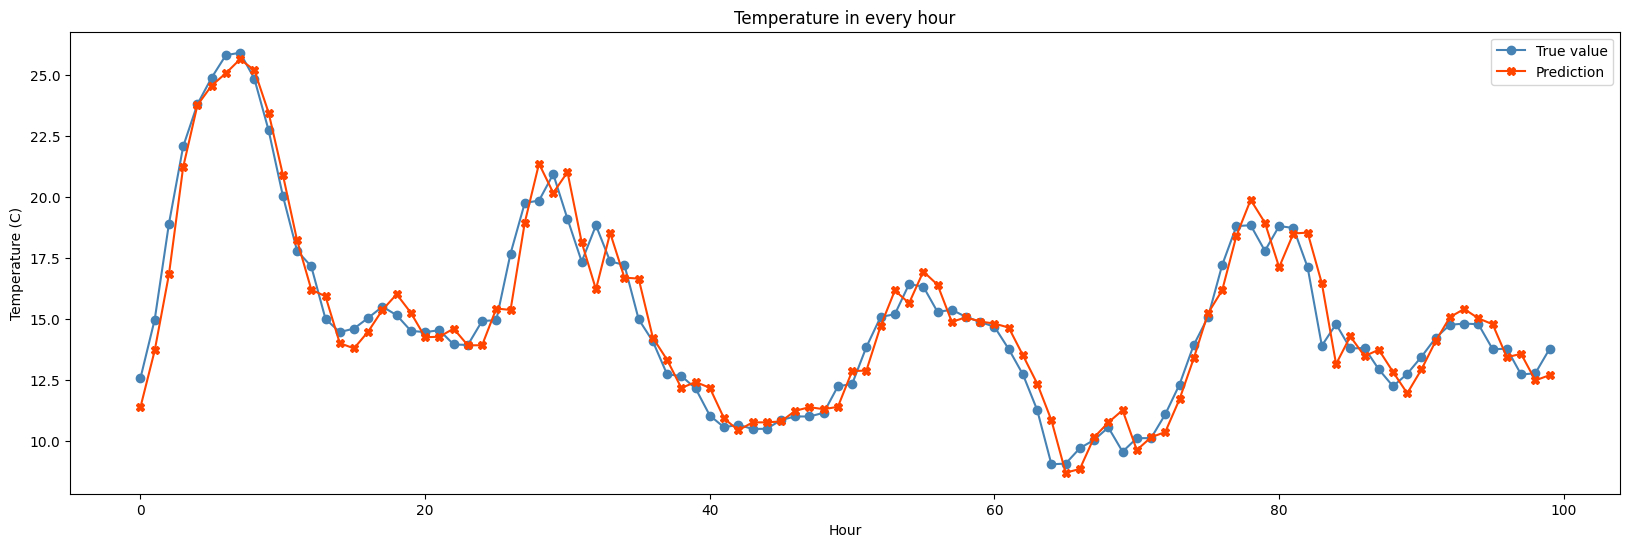

In [14]:
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hour')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()
plot_difference(y_test[:100], outputs)